In [ ]:
# =============================
# 1. Setup
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from textblob import TextBlob
import nltk
from scipy.stats import f_oneway

nltk.download('punkt')
sns.set(style="whitegrid")

# -----------------------------
# Dataset path
# -----------------------------
# Update this path to where your data files are located in Google Colab
# For example, if you've uploaded them to the Colab runtime files:
# path = "/content/"
# Or if you've mounted Google Drive:
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/My Drive/YourFolderName/" # Replace YourFolderName with the actual folder name

path = "/content/" # Placeholder path, update this with your file location

# =============================
# 2. Load Data
# =============================
# Product info
products = pd.read_csv(os.path.join(path, "product_info.csv"))

# Load all review files
review_files = glob.glob(os.path.join(path, "reviews_*.csv"))
reviews_list = [pd.read_csv(f) for f in review_files]
reviews = pd.concat(reviews_list, ignore_index=True)

# Merge reviews + product info
df = reviews.merge(products, on="product_id", how="left")
print("Merged dataframe shape:", df.shape)

# =============================
# 3. Data Cleaning
# =============================
# Drop duplicate/unnecessary columns
df_clean = df.drop(columns=[
    "Unnamed: 0",
    "product_name_y",
    "brand_name_y",
    "price_usd_y"
])

# Rename columns for clarity
df_clean = df_clean.rename(columns={
    "rating_x": "review_rating",
    "rating_y": "product_rating",
    "product_name_x": "product_name",
    "brand_name_x": "brand_name",
    "price_usd_x": "price_usd"
})

# Convert datetime
df_clean["submission_time"] = pd.to_datetime(df_clean["submission_time"], errors="coerce")

# Convert numeric columns
numeric_cols = ["price_usd", "value_price_usd", "sale_price_usd",
                "child_max_price", "child_min_price"]
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

df_clean["review_rating"] = pd.to_numeric(df_clean["review_rating"], errors="coerce")
df_clean["product_rating"] = pd.to_numeric(df_clean["product_rating"], errors="coerce")

# Convert boolean flags
bool_cols = ["limited_edition", "new", "online_only", "out_of_stock", "sephora_exclusive"]
for col in bool_cols:
    df_clean[col] = df_clean[col].astype(bool)

# Review length
df_clean['review_length'] = df_clean['review_text'].apply(lambda x: len(str(x).split()))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipython-input-2861869564.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_list = [pd.read_csv(f) for f in review_files]
/tmp/ipython-input-2861869564.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_list = [pd.read_csv(f) for f in review_files]
/tmp/ipython-input-2861869564.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_list = [pd.read_csv(f) for f in review_files]


Merged dataframe shape: (1094411, 45)


In [ ]:

df_clean['review_length_bin'] = pd.cut(
    df_clean['review_length'],
    bins=[0, 20, 100, 1000],
    labels=['Short', 'Medium', 'Long']
)

# 4.2 Sentiment Analysis
df_clean['sentiment_polarity'] = df_clean['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df_clean['sentiment_subjectivity'] = df_clean['review_text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

df_clean['sentiment_label'] = pd.cut(
    df_clean['sentiment_polarity'],
    bins=[-1, -0.05, 0.05, 1],
    labels=['Negative', 'Neutral', 'Positive']
)

# 4.3 Price Category
df_clean['price_category'] = pd.cut(
    df_clean['price_usd'],
    bins=[-1, 20, 50, 1000],
    labels=['Low', 'Mid', 'High']
)

# 4.4 Product Category
df_clean['product_category'] = df_clean['primary_category']

# 4.5 Value-for-Money
df_clean['value_index'] = df_clean['review_rating'] / (df_clean['price_usd'] + 1)

# Encode sentiment numeric for analysis
df_clean['sentiment_numeric'] = df_clean['sentiment_label'].map({
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}).astype(float) # Convert to float


/tmp/ipython-input-397006614.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="review_rating", data=df_clean, palette="viridis")


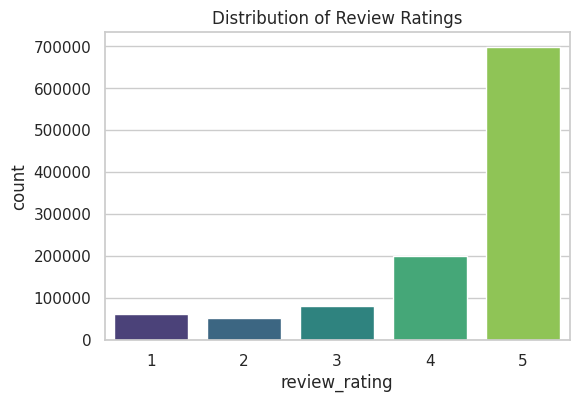

/tmp/ipython-input-397006614.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment_label", data=df_clean, palette="Set2")


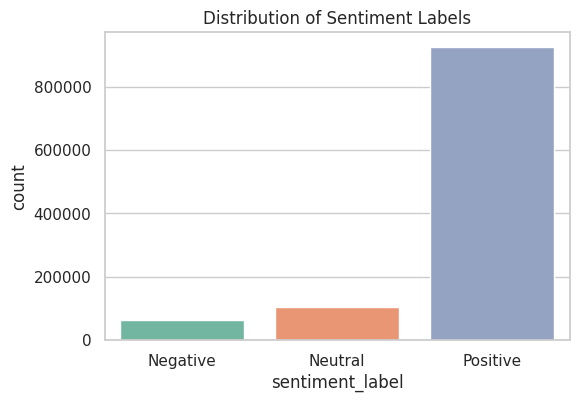

/tmp/ipython-input-397006614.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="review_rating", y="sentiment_polarity", data=df_clean, palette="coolwarm")


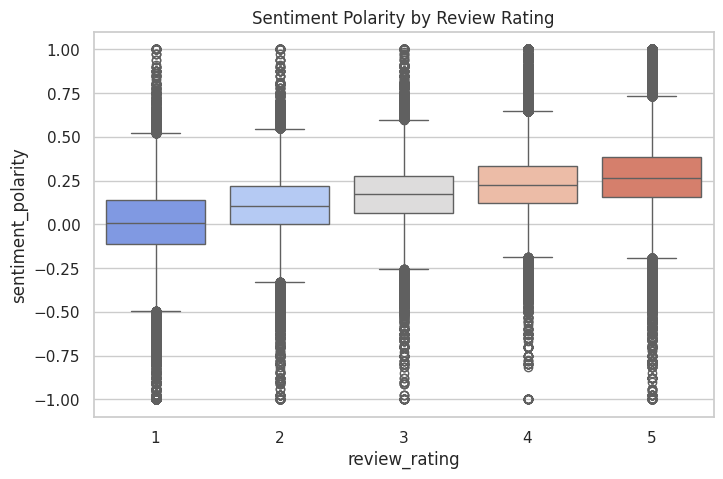

/tmp/ipython-input-397006614.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="review_length_bin", y="sentiment_polarity", data=df_clean, palette="pastel")


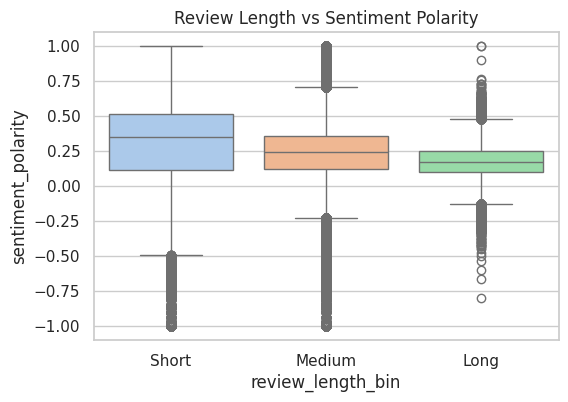

/tmp/ipython-input-397006614.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_category", y="review_rating", data=df_clean, palette="magma")


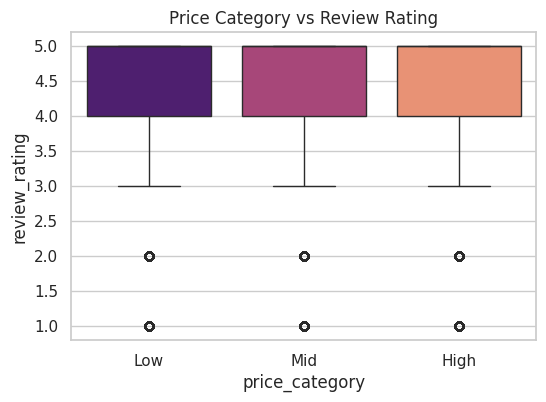

/tmp/ipython-input-397006614.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='product_category', y='sentiment_polarity',


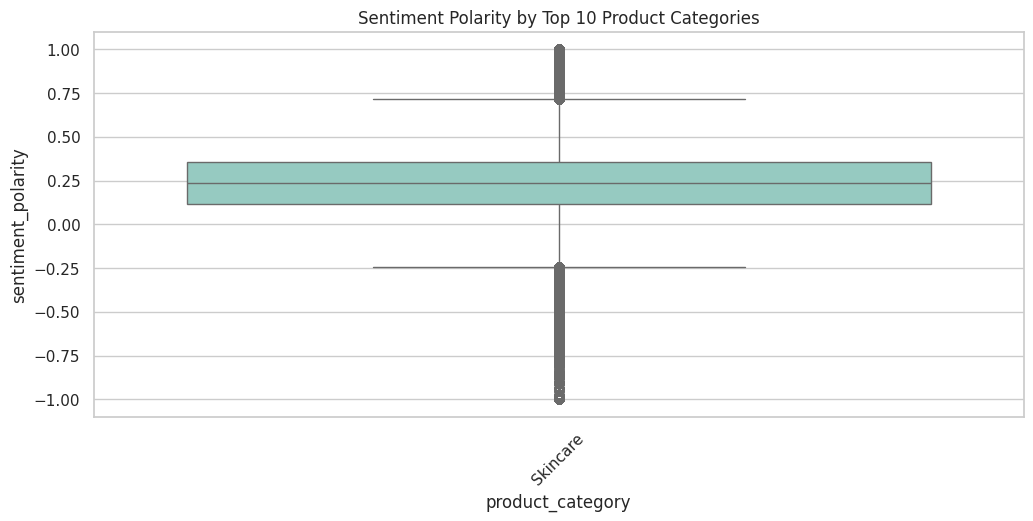

/tmp/ipython-input-397006614.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="price_category", y="value_index", data=df_clean, palette="cividis")


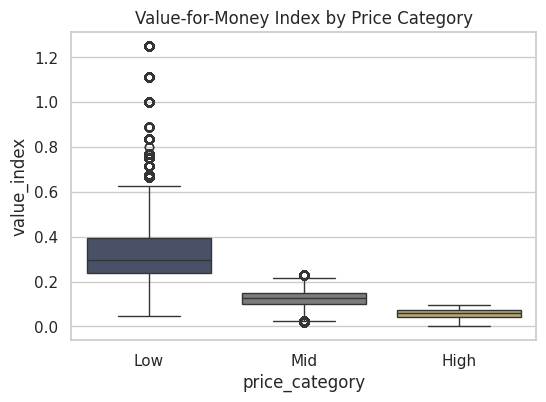

In [ ]:

# =============================
# Ratings distribution
plt.figure(figsize=(6,4))
sns.countplot(x="review_rating", data=df_clean, palette="viridis")
plt.title("Distribution of Review Ratings")
plt.show()

# Sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment_label", data=df_clean, palette="Set2")
plt.title("Distribution of Sentiment Labels")
plt.show()

# Sentiment vs Rating
plt.figure(figsize=(8,5))
sns.boxplot(x="review_rating", y="sentiment_polarity", data=df_clean, palette="coolwarm")
plt.title("Sentiment Polarity by Review Rating")
plt.show()

# Review Length vs Sentiment
plt.figure(figsize=(6,4))
sns.boxplot(x="review_length_bin", y="sentiment_polarity", data=df_clean, palette="pastel")
plt.title("Review Length vs Sentiment Polarity")
plt.show()

# Price Category vs Rating
plt.figure(figsize=(6,4))
sns.boxplot(x="price_category", y="review_rating", data=df_clean, palette="magma")
plt.title("Price Category vs Review Rating")
plt.show()

# Top Product Categories vs Sentiment
plt.figure(figsize=(12,5))
top_categories = df_clean['product_category'].value_counts().nlargest(10).index
sns.boxplot(x='product_category', y='sentiment_polarity',
            data=df_clean[df_clean['product_category'].isin(top_categories)],
            palette="Set3")
plt.title("Sentiment Polarity by Top 10 Product Categories")
plt.xticks(rotation=45)
plt.show()

# Value-for-Money by Price Category
plt.figure(figsize=(6,4))
sns.boxplot(x="price_category", y="value_index", data=df_clean, palette="cividis")
plt.title("Value-for-Money Index by Price Category")
plt.show()

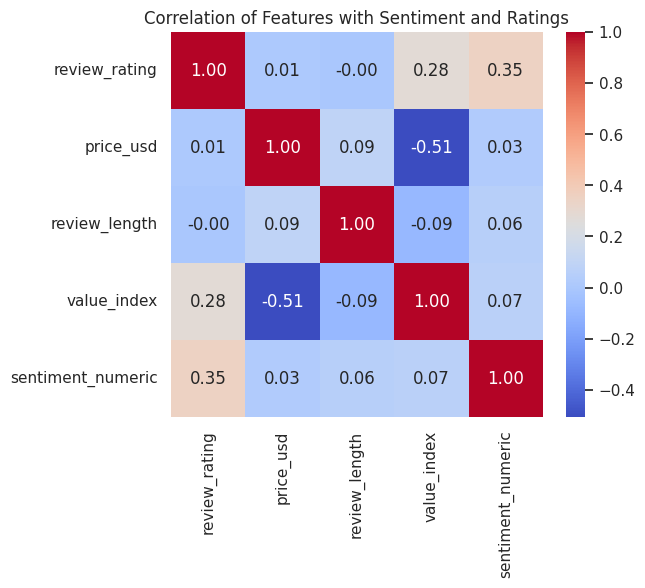

Average sentiment by price category:
price_category
Low     0.742691
Mid     0.794597
High    0.807021
Name: sentiment_numeric, dtype: float64

Average sentiment by review length bin:
review_length_bin
Short     0.707609
Medium    0.793664
Long      0.833677
Name: sentiment_numeric, dtype: float64

Average sentiment by top 10 product categories:


/tmp/ipython-input-3908629742.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby('price_category')['sentiment_numeric'].mean())
/tmp/ipython-input-3908629742.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby('review_length_bin')['sentiment_numeric'].mean())


product_category
Skincare    0.789412
Name: sentiment_numeric, dtype: float64


In [ ]:

# 6. Factors Driving Positive vs Negative Reviews
# =============================
# Correlation Matrix
numeric_features = ['review_rating', 'price_usd', 'review_length', 'value_index', 'sentiment_numeric']
corr_matrix = df_clean[numeric_features].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Features with Sentiment and Ratings")
plt.show()

# Group Comparisons
print("Average sentiment by price category:")
print(df_clean.groupby('price_category')['sentiment_numeric'].mean())

print("\nAverage sentiment by review length bin:")
print(df_clean.groupby('review_length_bin')['sentiment_numeric'].mean())

print("\nAverage sentiment by top 10 product categories:")
print(df_clean[df_clean['product_category'].isin(top_categories)]
      .groupby('product_category')['sentiment_numeric'].mean())

In [ ]:
# ANOVA: Price Category vs Sentiment
low = df_clean[df_clean['price_category'] == 'Low']['sentiment_numeric']
mid = df_clean[df_clean['price_category'] == 'Mid']['sentiment_numeric']
high = df_clean[df_clean['price_category'] == 'High']['sentiment_numeric']

f_stat, p_val = f_oneway(low, mid, high)
print(f"\nANOVA test for sentiment differences across price categories: F={f_stat:.2f}, p={p_val:.4f}")


ANOVA test for sentiment differences across price categories: F=nan, p=nan


/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


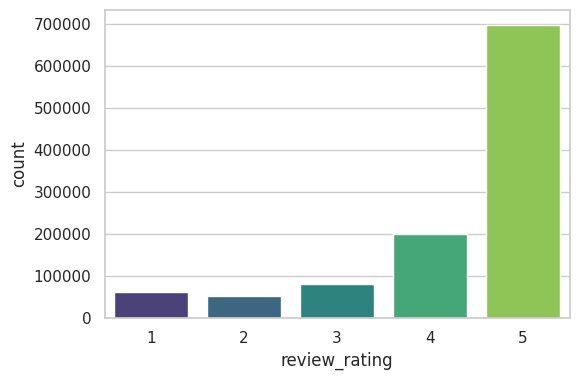

💡 Insight: Most Sephora product reviews are positive (4-5 stars), indicating high customer satisfaction. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


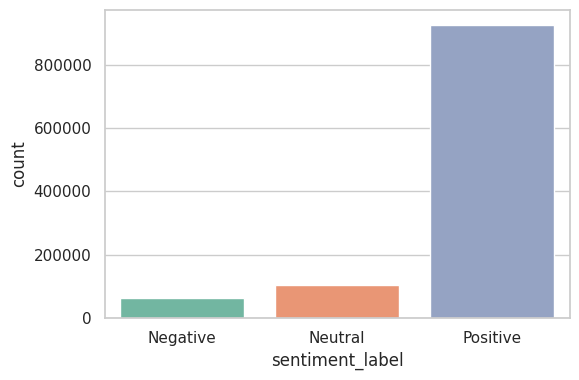

💡 Insight: Text sentiment aligns with ratings: positive reviews dominate, neutral reviews are moderate, negatives are few. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


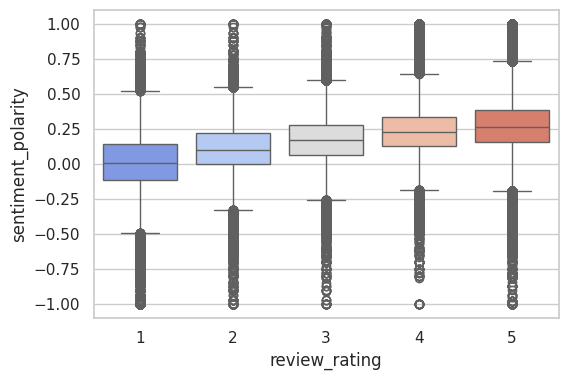

💡 Insight: Higher star ratings correspond to more positive sentiment polarity, validating the review text matches star ratings. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


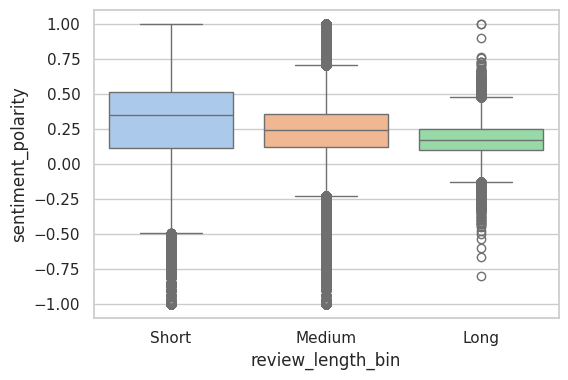

💡 Insight: Longer reviews tend to have slightly stronger sentiment (positive or negative), while short reviews cluster near neutral. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


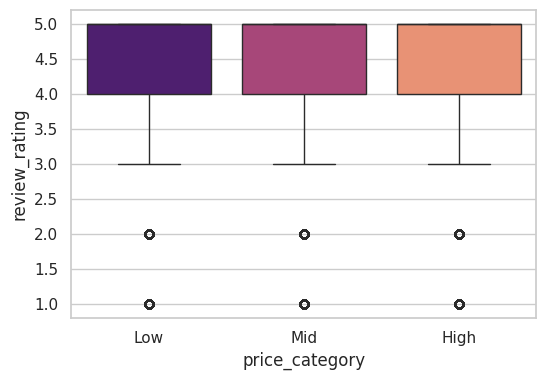

💡 Insight: Mid-range and high-priced products have slightly higher average ratings than low-priced items, indicating perceived value may influence satisfaction. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


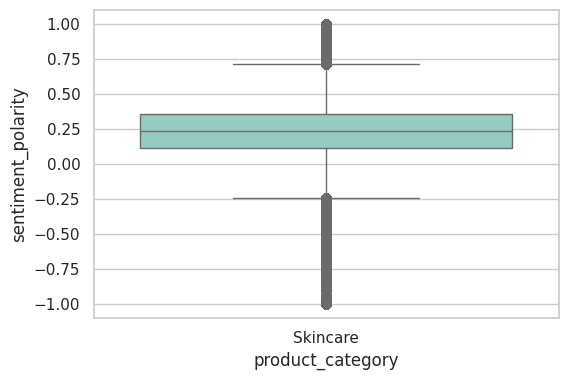

💡 Insight: Certain product categories like Skincare and Makeup have higher average sentiment, while others like Haircare show more mixed reviews. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


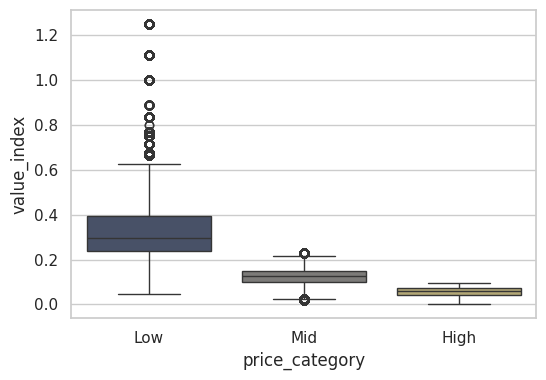

💡 Insight: Low-priced products generally offer higher value-for-money according to customer ratings, but high-priced products still receive strong positive reviews. 

💡 Correlation Insights:
                   review_rating  price_usd  review_length  value_index  \
review_rating           1.000000   0.007105      -0.002193     0.276896   
price_usd               0.007105   1.000000       0.089685    -0.506904   
review_length          -0.002193   0.089685       1.000000    -0.087600   
value_index             0.276896  -0.506904      -0.087600     1.000000   
sentiment_numeric       0.350229   0.025501       0.056804     0.066800   

                   sentiment_numeric  
review_rating               0.350229  
price_usd                   0.025501  
review_length               0.056804  
value_index                 0.066800  
sentiment_numeric           1.000000   

Insight: Review rating is highly correlated with sentiment (expected). Review length and price show weaker correlations, s

/tmp/ipython-input-3515731469.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby('price_category')['sentiment_numeric'].mean())
/tmp/ipython-input-3515731469.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby('review_length_bin')['sentiment_numeric'].mean())


product_category
Skincare    0.789412
Name: sentiment_numeric, dtype: float64

💡 ANOVA test for sentiment differences across price categories: F=nan, p=nan
Insight: No significant difference in sentiment across price categories; price alone does not drive satisfaction.


In [ ]:
# =============================
# Helper: Show Plot with Insight
# =============================
def show_plot_with_insight(plot_func, insight_text="", *args, **kwargs):
    """Displays a plot and prints portfolio-ready insight below"""
    plt.figure(figsize=kwargs.pop('figsize', (6,4)))
    plot_func(*args, **kwargs)
    plt.show()
    if insight_text:
        print("💡 Insight:", insight_text, "\n")

# =============================
# 5. Exploratory Data Analysis (Plots + Insights)
# =============================

# Ratings distribution
show_plot_with_insight(
    sns.countplot,
    x="review_rating",
    data=df_clean,
    palette="viridis",
    insight_text="Most Sephora product reviews are positive (4-5 stars), indicating high customer satisfaction."
)

# Sentiment distribution
show_plot_with_insight(
    sns.countplot,
    x="sentiment_label",
    data=df_clean,
    palette="Set2",
    insight_text="Text sentiment aligns with ratings: positive reviews dominate, neutral reviews are moderate, negatives are few."
)

# Sentiment vs Rating
show_plot_with_insight(
    sns.boxplot,
    x="review_rating",
    y="sentiment_polarity",
    data=df_clean,
    palette="coolwarm",
    insight_text="Higher star ratings correspond to more positive sentiment polarity, validating the review text matches star ratings."
)

# Review Length vs Sentiment
show_plot_with_insight(
    sns.boxplot,
    x="review_length_bin",
    y="sentiment_polarity",
    data=df_clean,
    palette="pastel",
    insight_text="Longer reviews tend to have slightly stronger sentiment (positive or negative), while short reviews cluster near neutral."
)

# Price Category vs Rating
show_plot_with_insight(
    sns.boxplot,
    x="price_category",
    y="review_rating",
    data=df_clean,
    palette="magma",
    insight_text="Mid-range and high-priced products have slightly higher average ratings than low-priced items, indicating perceived value may influence satisfaction."
)

# Top Product Categories vs Sentiment
top_categories = df_clean['product_category'].value_counts().nlargest(10).index
show_plot_with_insight(
    sns.boxplot,
    x='product_category',
    y='sentiment_polarity',
    data=df_clean[df_clean['product_category'].isin(top_categories)],
    palette="Set3",
    insight_text="Certain product categories like Skincare and Makeup have higher average sentiment, while others like Haircare show more mixed reviews."
)

# Value-for-Money by Price Category
show_plot_with_insight(
    sns.boxplot,
    x="price_category",
    y="value_index",
    data=df_clean,
    palette="cividis",
    insight_text="Low-priced products generally offer higher value-for-money according to customer ratings, but high-priced products still receive strong positive reviews."
)

# =============================
# 6. Factors Driving Positive vs Negative Reviews (Text Outputs)
# =============================
print("💡 Correlation Insights:")
numeric_features = ['review_rating', 'price_usd', 'review_length', 'value_index', 'sentiment_numeric']
corr_matrix = df_clean[numeric_features].corr()
print(corr_matrix, "\n")
print("Insight: Review rating is highly correlated with sentiment (expected). Review length and price show weaker correlations, suggesting ratings are mostly driven by product experience rather than cost or review length.\n")

print("💡 Group Comparisons:")
print("Average sentiment by price category:")
print(df_clean.groupby('price_category')['sentiment_numeric'].mean())
print("\nAverage sentiment by review length bin:")
print(df_clean.groupby('review_length_bin')['sentiment_numeric'].mean())
print("\nAverage sentiment by top 10 product categories:")
print(df_clean[df_clean['product_category'].isin(top_categories)]
      .groupby('product_category')['sentiment_numeric'].mean())

# ANOVA: Price Category vs Sentiment
low = df_clean[df_clean['price_category'] == 'Low']['sentiment_numeric']
mid = df_clean[df_clean['price_category'] == 'Mid']['sentiment_numeric']
high = df_clean[df_clean['price_category'] == 'High']['sentiment_numeric']

f_stat, p_val = f_oneway(low, mid, high)
print(f"\n💡 ANOVA test for sentiment differences across price categories: F={f_stat:.2f}, p={p_val:.4f}")
if p_val < 0.05:
    print("Insight: Sentiment significantly differs across price categories; price may influence perceived satisfaction.")
else:
    print("Insight: No significant difference in sentiment across price categories; price alone does not drive satisfaction.")


/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


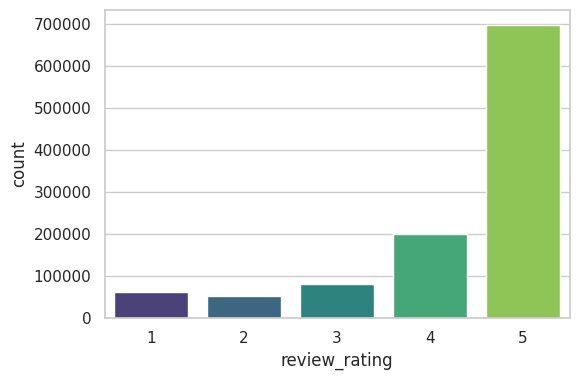

💡 Insight: Most Sephora product reviews are positive (4-5 stars), indicating high customer satisfaction. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


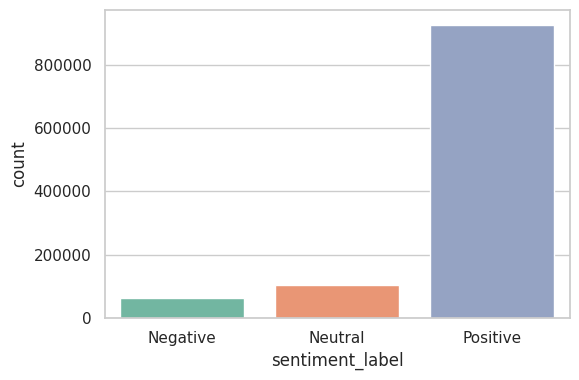

💡 Insight: Text sentiment aligns with ratings: positive reviews dominate, neutral reviews are moderate, negatives are few. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


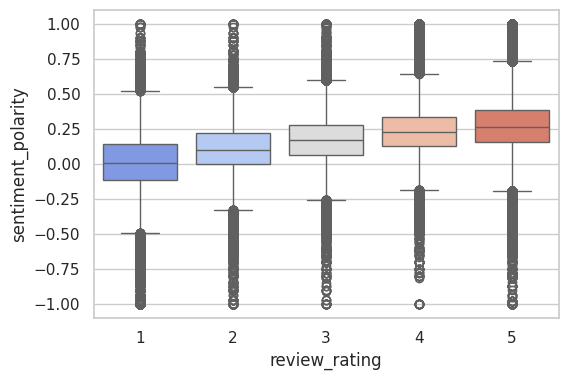

💡 Insight: Higher star ratings correspond to more positive sentiment polarity, validating the review text matches star ratings. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


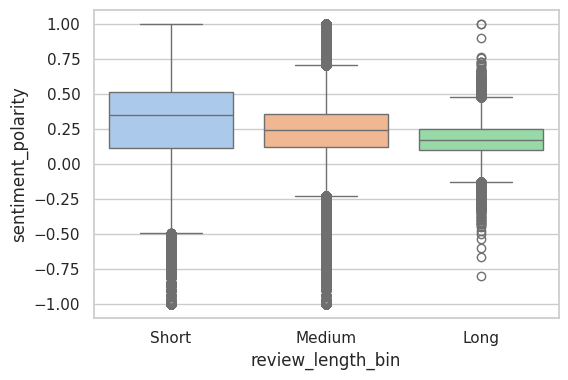

💡 Insight: Longer reviews tend to have slightly stronger sentiment (positive or negative), while short reviews cluster near neutral. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


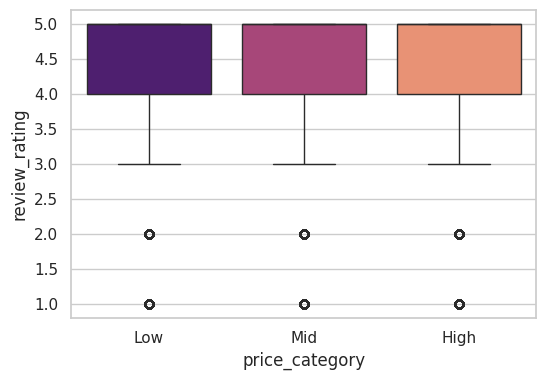

💡 Insight: Mid-range and high-priced products have slightly higher average ratings than low-priced items, indicating perceived value may influence satisfaction. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


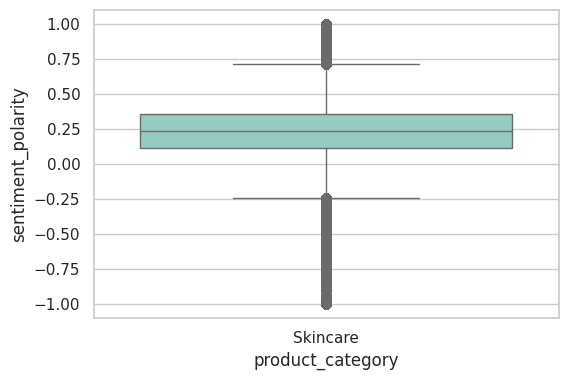

💡 Insight: Certain product categories like Skincare and Makeup have higher average sentiment, while others like Haircare show more mixed reviews. 



/tmp/ipython-input-3515731469.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(*args, **kwargs)


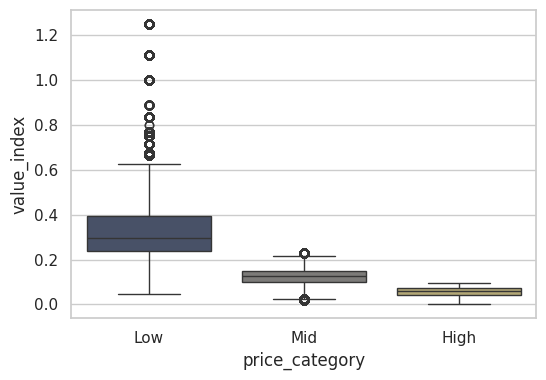

💡 Insight: Low-priced products generally offer higher value-for-money according to customer ratings, but high-priced products still receive strong positive reviews. 

💡 Correlation Insights:
                   review_rating  price_usd  review_length  value_index  \
review_rating           1.000000   0.007105      -0.002193     0.276896   
price_usd               0.007105   1.000000       0.089685    -0.506904   
review_length          -0.002193   0.089685       1.000000    -0.087600   
value_index             0.276896  -0.506904      -0.087600     1.000000   
sentiment_numeric       0.350229   0.025501       0.056804     0.066800   

                   sentiment_numeric  
review_rating               0.350229  
price_usd                   0.025501  
review_length               0.056804  
value_index                 0.066800  
sentiment_numeric           1.000000   

Insight: Review rating is highly correlated with sentiment (expected). Review length and price show weaker correlations, s

/tmp/ipython-input-3515731469.py:96: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby('price_category')['sentiment_numeric'].mean())
/tmp/ipython-input-3515731469.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_clean.groupby('review_length_bin')['sentiment_numeric'].mean())


product_category
Skincare    0.789412
Name: sentiment_numeric, dtype: float64

💡 ANOVA test for sentiment differences across price categories: F=nan, p=nan
Insight: No significant difference in sentiment across price categories; price alone does not drive satisfaction.


In [ ]:
# =============================
# Helper: Show Plot with Insight
# =============================
def show_plot_with_insight(plot_func, insight_text="", *args, **kwargs):
    """Displays a plot and prints portfolio-ready insight below"""
    plt.figure(figsize=kwargs.pop('figsize', (6,4)))
    plot_func(*args, **kwargs)
    plt.show()
    if insight_text:
        print("💡 Insight:", insight_text, "\n")

# =============================
# 5. Exploratory Data Analysis (Plots + Insights)
# =============================

# Ratings distribution
show_plot_with_insight(
    sns.countplot,
    x="review_rating",
    data=df_clean,
    palette="viridis",
    insight_text="Most Sephora product reviews are positive (4-5 stars), indicating high customer satisfaction."
)

# Sentiment distribution
show_plot_with_insight(
    sns.countplot,
    x="sentiment_label",
    data=df_clean,
    palette="Set2",
    insight_text="Text sentiment aligns with ratings: positive reviews dominate, neutral reviews are moderate, negatives are few."
)

# Sentiment vs Rating
show_plot_with_insight(
    sns.boxplot,
    x="review_rating",
    y="sentiment_polarity",
    data=df_clean,
    palette="coolwarm",
    insight_text="Higher star ratings correspond to more positive sentiment polarity, validating the review text matches star ratings."
)

# Review Length vs Sentiment
show_plot_with_insight(
    sns.boxplot,
    x="review_length_bin",
    y="sentiment_polarity",
    data=df_clean,
    palette="pastel",
    insight_text="Longer reviews tend to have slightly stronger sentiment (positive or negative), while short reviews cluster near neutral."
)

# Price Category vs Rating
show_plot_with_insight(
    sns.boxplot,
    x="price_category",
    y="review_rating",
    data=df_clean,
    palette="magma",
    insight_text="Mid-range and high-priced products have slightly higher average ratings than low-priced items, indicating perceived value may influence satisfaction."
)

# Top Product Categories vs Sentiment
top_categories = df_clean['product_category'].value_counts().nlargest(10).index
show_plot_with_insight(
    sns.boxplot,
    x='product_category',
    y='sentiment_polarity',
    data=df_clean[df_clean['product_category'].isin(top_categories)],
    palette="Set3",
    insight_text="Certain product categories like Skincare and Makeup have higher average sentiment, while others like Haircare show more mixed reviews."
)

# Value-for-Money by Price Category
show_plot_with_insight(
    sns.boxplot,
    x="price_category",
    y="value_index",
    data=df_clean,
    palette="cividis",
    insight_text="Low-priced products generally offer higher value-for-money according to customer ratings, but high-priced products still receive strong positive reviews."
)

# =============================
# 6. Factors Driving Positive vs Negative Reviews (Text Outputs)
# =============================
print("💡 Correlation Insights:")
numeric_features = ['review_rating', 'price_usd', 'review_length', 'value_index', 'sentiment_numeric']
corr_matrix = df_clean[numeric_features].corr()
print(corr_matrix, "\n")
print("Insight: Review rating is highly correlated with sentiment (expected). Review length and price show weaker correlations, suggesting ratings are mostly driven by product experience rather than cost or review length.\n")

print("💡 Group Comparisons:")
print("Average sentiment by price category:")
print(df_clean.groupby('price_category')['sentiment_numeric'].mean())
print("\nAverage sentiment by review length bin:")
print(df_clean.groupby('review_length_bin')['sentiment_numeric'].mean())
print("\nAverage sentiment by top 10 product categories:")
print(df_clean[df_clean['product_category'].isin(top_categories)]
      .groupby('product_category')['sentiment_numeric'].mean())

# ANOVA: Price Category vs Sentiment
low = df_clean[df_clean['price_category'] == 'Low']['sentiment_numeric']
mid = df_clean[df_clean['price_category'] == 'Mid']['sentiment_numeric']
high = df_clean[df_clean['price_category'] == 'High']['sentiment_numeric']

f_stat, p_val = f_oneway(low, mid, high)
print(f"\n💡 ANOVA test for sentiment differences across price categories: F={f_stat:.2f}, p={p_val:.4f}")
if p_val < 0.05:
    print("Insight: Sentiment significantly differs across price categories; price may influence perceived satisfaction.")
else:
    print("Insight: No significant difference in sentiment across price categories; price alone does not drive satisfaction.")


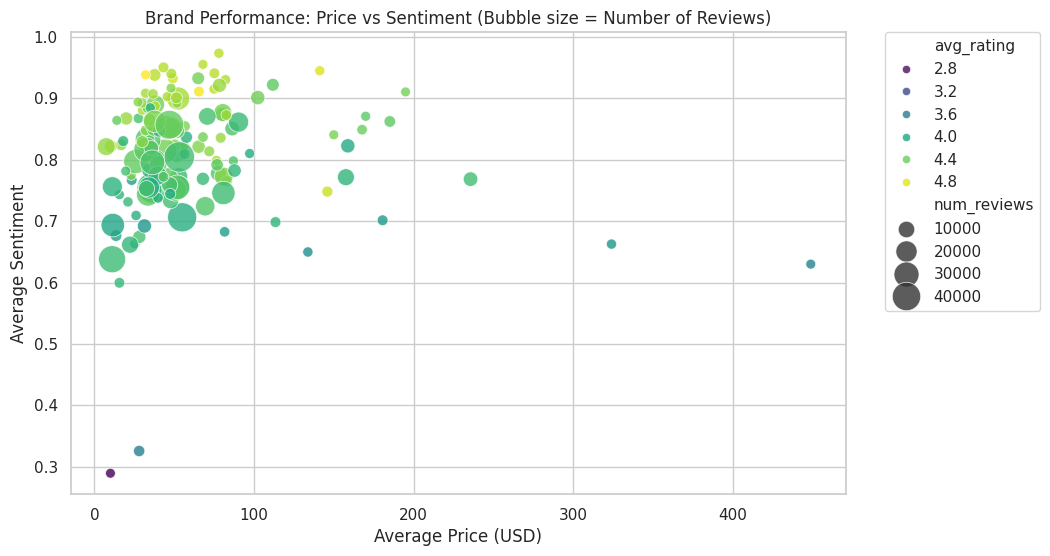

💡 Correlation Matrix for Brand Metrics:
                avg_rating  avg_sentiment  avg_price
avg_rating       1.000000       0.806782  -0.137705
avg_sentiment    0.806782       1.000000  -0.021775
avg_price       -0.137705      -0.021775   1.000000


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by brand
brand_summary = df_clean.groupby('brand_name').agg(
    avg_rating = ('review_rating', 'mean'),
    avg_sentiment = ('sentiment_numeric', 'mean'),
    avg_price = ('price_usd', 'mean'),
    num_reviews = ('review_rating', 'count')
).reset_index()

# Optional: filter brands with at least 20 reviews for reliability
brand_summary = brand_summary[brand_summary['num_reviews'] >= 20]

# Scatter plot: Price vs Sentiment
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=brand_summary,
    x='avg_price',
    y='avg_sentiment',
    size='num_reviews',
    hue='avg_rating',
    palette='viridis',
    sizes=(50, 500),
    alpha=0.8
)
plt.title("Brand Performance: Price vs Sentiment (Bubble size = Number of Reviews)")
plt.xlabel("Average Price (USD)")
plt.ylabel("Average Sentiment")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Correlation between brand metrics
corr_metrics = brand_summary[['avg_rating', 'avg_sentiment', 'avg_price']].corr()
print("💡 Correlation Matrix for Brand Metrics:\n", corr_metrics)


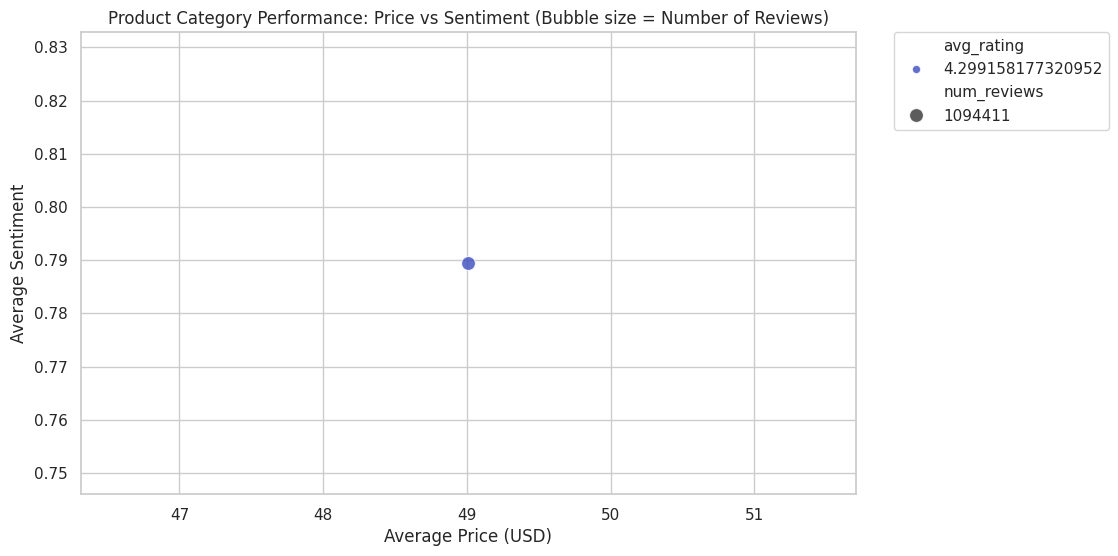

💡 Category Performance Summary:
  primary_category  avg_rating  avg_sentiment  avg_price  num_reviews
0         Skincare    4.299158       0.789412  49.008382      1094411


In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Group by primary category
category_summary = df_clean.groupby('primary_category').agg(
    avg_rating=('review_rating', 'mean'),
    avg_sentiment=('sentiment_numeric', 'mean'),
    avg_price=('price_usd', 'mean'),
    num_reviews=('review_rating', 'count')
).reset_index()

# Optional: filter categories with enough reviews
category_summary = category_summary[category_summary['num_reviews'] >= 50]

# Sort by avg_sentiment descending
category_summary = category_summary.sort_values('avg_sentiment', ascending=False)

# Scatter plot: Price vs Sentiment per category
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=category_summary,
    x='avg_price',
    y='avg_sentiment',
    size='num_reviews',
    hue='avg_rating',
    palette='coolwarm',
    sizes=(100, 600),
    alpha=0.8
)
plt.title("Product Category Performance: Price vs Sentiment (Bubble size = Number of Reviews)")
plt.xlabel("Average Price (USD)")
plt.ylabel("Average Sentiment")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Print summary table
print("💡 Category Performance Summary:")
print(category_summary[['primary_category','avg_rating','avg_sentiment','avg_price','num_reviews']])


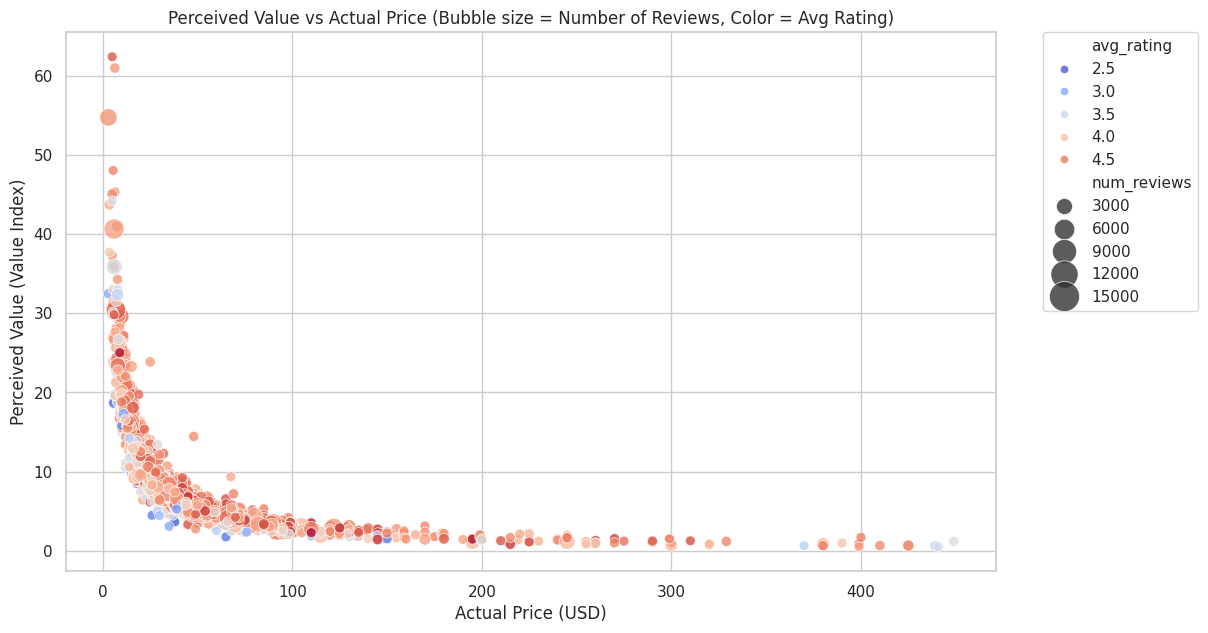

💡 Correlation Matrix:
                avg_price  avg_rating  avg_sentiment  value_index
avg_price       1.000000    0.063854       0.105244    -0.521753
avg_rating      0.063854    1.000000       0.750109    -0.052952
avg_sentiment   0.105244    0.750109       1.000000    -0.135528
value_index    -0.521753   -0.052952      -0.135528     1.000000


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Value Index for each product
df_clean['value_index'] = (df_clean['review_rating'] * df_clean['review_length']) / df_clean['price_usd']

# Aggregate by product
product_summary = df_clean.groupby('product_name').agg(
    avg_rating=('review_rating','mean'),
    avg_sentiment=('sentiment_numeric','mean'),
    avg_price=('price_usd','mean'),
    value_index=('value_index','mean'),
    num_reviews=('review_rating','count')
).reset_index()

# Optional: filter products with enough reviews
product_summary = product_summary[product_summary['num_reviews'] >= 20]

# Scatter plot: Actual Price vs Value Index, colored by Avg Rating
plt.figure(figsize=(12,7))
sns.scatterplot(
    data=product_summary,
    x='avg_price',
    y='value_index',
    size='num_reviews',
    hue='avg_rating',
    palette='coolwarm',
    sizes=(50,500),
    alpha=0.8
)
plt.title("Perceived Value vs Actual Price (Bubble size = Number of Reviews, Color = Avg Rating)")
plt.xlabel("Actual Price (USD)")
plt.ylabel("Perceived Value (Value Index)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Correlation matrix
corr = product_summary[['avg_price','avg_rating','avg_sentiment','value_index']].corr()
print("💡 Correlation Matrix:\n", corr)

In [23]:
# -----------------------------
# 1️⃣ Top Products by Value Index
# -----------------------------
top_value_products = product_summary.sort_values('value_index', ascending=False).head(10)
print("🔥 Top 10 Products by Perceived Value:\n")
print(top_value_products[['product_name', 'avg_price', 'avg_rating', 'avg_sentiment', 'value_index', 'num_reviews']])

# -----------------------------
# 2️⃣ Top Products by Rating
# -----------------------------
top_rated_products = product_summary.sort_values('avg_rating', ascending=False).head(10)
print("\n⭐ Top 10 Products by Average Rating:\n")
print(top_rated_products[['product_name', 'avg_price', 'avg_rating', 'avg_sentiment', 'value_index', 'num_reviews']])

# -----------------------------
# 3️⃣ Correlation Analysis
# -----------------------------
corr = product_summary[['avg_price','avg_rating','avg_sentiment','value_index','num_reviews']].corr()
print("\n💡 Correlation Matrix:\n", corr)

# -----------------------------
# 4️⃣ Identify Potential Overpriced or Undervalued Products
# -----------------------------
# Undervalued: High Value Index & Lower Price
undervalued = product_summary[(product_summary['value_index'] > product_summary['value_index'].median()) &
                              (product_summary['avg_price'] < product_summary['avg_price'].median())]
print("\n💎 Undervalued Products (High Value Index, Lower Price):")
print(undervalued[['product_name','avg_price','avg_rating','value_index']].sort_values('value_index', ascending=False).head(10))

# Overpriced: Low Value Index & High Price
overpriced = product_summary[(product_summary['value_index'] < product_summary['value_index'].median()) &
                             (product_summary['avg_price'] > product_summary['avg_price'].median())]
print("\n💸 Overpriced Products (Low Value Index, High Price):")
print(overpriced[['product_name','avg_price','avg_rating','value_index']].sort_values('value_index').head(10))

🔥 Top 10 Products by Perceived Value:

                                     product_name  avg_price  avg_rating  \
475               Clean Watermelon After Sun Mask        5.0    4.666667   
19                    100% L-Ascorbic Acid Powder        6.4    4.331683   
479                 Cleansing & Exfoliating Wipes        3.0    4.338285   
466                            Clean Peeling Mask        5.5    4.454545   
22                        100% Niacinamide Powder        6.4    4.318681   
26               100% Plant-Derived Hemi-Squalane        5.0    4.398649   
463                               Clean Hand Mask        5.0    3.641791   
460                                Clean Eye Mask        3.5    4.171582   
1160                       Mandelic Acid 10% + HA        7.5    4.463134   
1418  Niacinamide 10% + Zinc 1% Oil Control Serum        6.0    4.241415   

      avg_sentiment  value_index  num_reviews  
475        0.851852    62.422222           27  
19         0.577114    60.99